# Check whether new initial and boundary conditions are reasonable

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import sys
sys.path.append('/home/users/birgal/')
import pickle
from nemo_python_git.utils import fix_lon_range, convert_to_teos10
from nemo_python_git.interpolation import regrid_array_cf, regrid_operator_cf
from nemo_python_git.ics_obcs import fill_ocean
from nemo_python_git.forcing import find_cesm2_file

In [2]:
base_folder = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

## Append a couple of columns at the end of the boundary condition

In [98]:
for var in ['AbsSal', 'ConsTemp', 'UVEL', 'VVEL','SSH','aice','sithick','sisnthick']:
    print(var)
    for month in range(2,13):
        dso = xr.open_dataset(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_{var}_test4_y1850m{month:02}.nc')
        slice_beg = dso.isel(x=slice(0,1))
        slice_end = dso.isel(x=slice(1439,None))
        dsn = xr.concat([dso, slice_end], dim='x')
        dsn.to_netcdf(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_{var}_test7_y1850m{month:02}.nc')

AbsSal
ConsTemp
UVEL
VVEL
SSH
aice
sithick
sisnthick


Maybe it has something to do with the halo? So I need to prepend and post pend a value?

In [235]:
dsW = xr.open_dataset(f'{base_folder}output/CESM2-test4/files/eANT025.L121_1d_18500101_18501231_grid_W_18500101-18500101.nc').isel(time_counter=0, y=-2)

In [236]:
kwagsU={'ylim':(600,0),'vmin':-0.2,'vmax':0.2,'cmap':cmocean.cm.balance, 'figsize':(14,4)}
kwagsV={'ylim':(600,0),'vmin':-0.2,'vmax':0.2,'cmap':cmocean.cm.balance, 'figsize':(14,4)}
kwagsW={'ylim':(600,0),'vmin':None,'vmax':None,'cmap':cmocean.cm.balance, 'figsize':(14,4)}
kwagsS={'ylim':(600,0),'vmin':33.5,'vmax':35.1,'cmap':cmocean.cm.balance, 'figsize':(14,4)}
kwagsT={'ylim':(600,0),'vmin':1,'vmax':4,'cmap':cmocean.cm.balance, 'figsize':(14,4)}

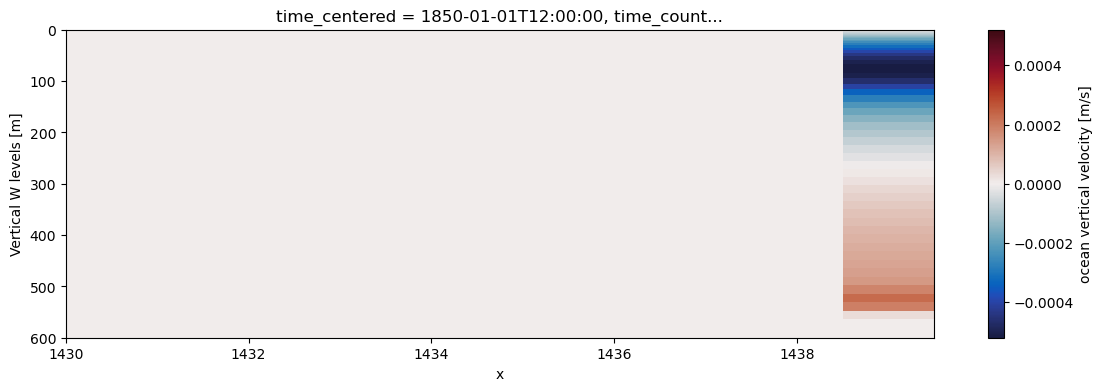

In [237]:
dsW.wo.plot(xlim=(1430,None), **kwagsW)

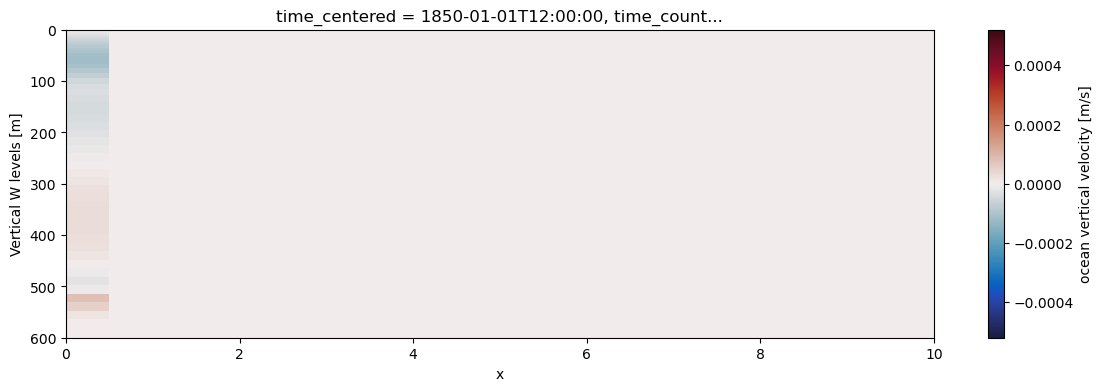

In [238]:
dsW.wo.plot(xlim=(0,10), **kwagsW)

Maybe it's not actually a bug??? Could it just be an artefact from how the halo gets applied?

That didn't work, so let's instead make sure that the end and start are equal

In [28]:
for var in ['AbsSal', 'ConsTemp', 'UVEL', 'VVEL','SSH','aice','sithick','sisnthick']:
    print(var)
    for month in range(2,13):
        dso = xr.open_dataset(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_{var}_test4_y1850m{month:02}.nc')
        dso_array = dso[var].values
        if var in ['AbsSal', 'ConsTemp', 'UVEL', 'VVEL']:
            dso_array[:,:,:,0] = dso_array[:,:,:,-1] 
            dso_array[:,:,:,1] = dso_array[:,:,:,-1] 
            dso_array[:,:,:,-2] = dso_array[:,:,:,-1] 
            dsn = dso.copy()
            dsn[var] = (('time_counter','deptht','y','x'), dso_array)
        else:
            dso_array[:,:,0] = dso_array[:,:,-1] 
            dso_array[:,:,1] = dso_array[:,:,-1] 
            dso_array[:,:,-2] = dso_array[:,:,-1] 
            dsn = dso.copy()
            dsn[var] = (('time_counter','y','x'), dso_array)
        dsn.to_netcdf(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_{var}_test6_y1850m{month:02}.nc')

AbsSal
ConsTemp
UVEL
VVEL
SSH
aice
sithick
sisnthick


In [97]:
nemo_mesh = xr.open_dataset(f'{base_folder}bathymetry/mesh_mask-20240305.nc').isel(time_counter=0)

In [49]:
ds = xr.open_dataset(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_ConsTemp_test4_y1850m02.nc')
ds = ds.assign({'deptht':(('deptht'),nemo_mesh.nav_lev.values)})

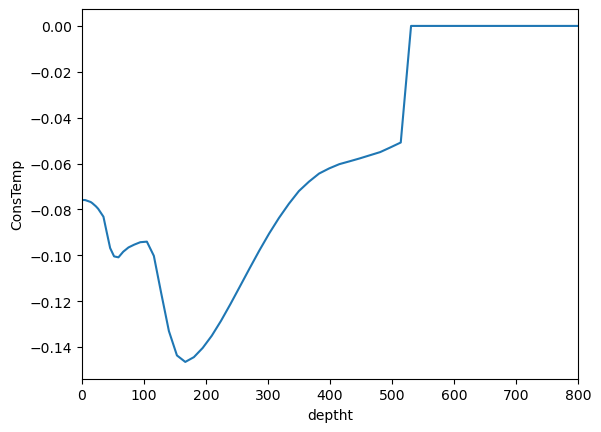

In [51]:
var='ConsTemp'
(ds.isel(time_counter=0,y=0, x=-1)[var] - ds.isel(time_counter=0,y=0, x=0)[var]).plot(xlim=(0,800))

In [52]:
bc = xr.open_dataset(f'{base_folder}eANT025-orig/bdyT_tra_y1979_eANT025.L121.nc')

In [210]:
dsu = xr.open_dataset(f'{base_folder}output/reference-4.2.2/files/eANT025.L121_1m_19790101_19791231_grid_U.nc').isel(time_counter=0)
dsv = xr.open_dataset(f'{base_folder}output/reference-4.2.2/files/eANT025.L121_1m_19790101_19791231_grid_V.nc').isel(time_counter=0)
dsw = xr.open_dataset(f'{base_folder}output/reference-4.2.2/files/eANT025.L121_1m_19790101_19791231_grid_W.nc').isel(time_counter=0)
dst = xr.open_dataset(f'{base_folder}output/reference-4.2.2/files/eANT025.L121_1m_19790101_19791231_grid_T.nc').isel(time_counter=0)

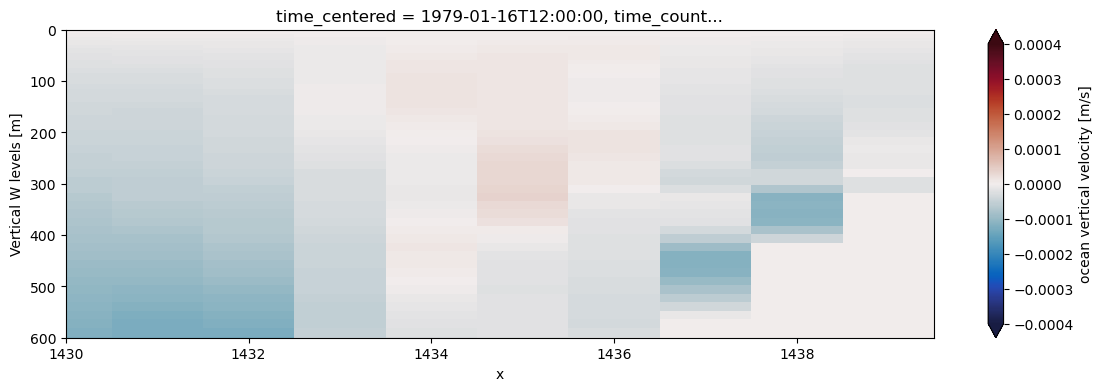

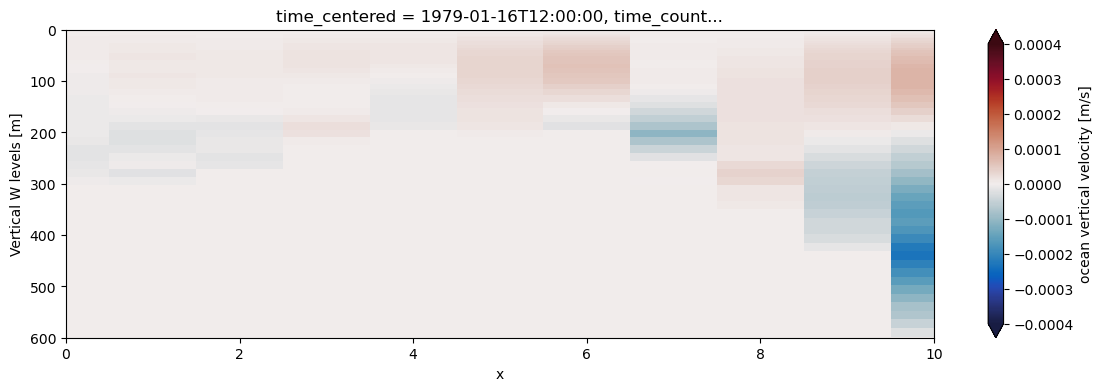

In [239]:
kwagsW={'ylim':(600,0),'vmin':-4e-4,'vmax':4e-4,'cmap':cmocean.cm.balance, 'figsize':(14,4)}
dsw.wo.isel(y=-3).plot(xlim=(1430,None), **kwagsW)
dsw.wo.isel(y=-3).plot(xlim=(0,10), **kwagsW)

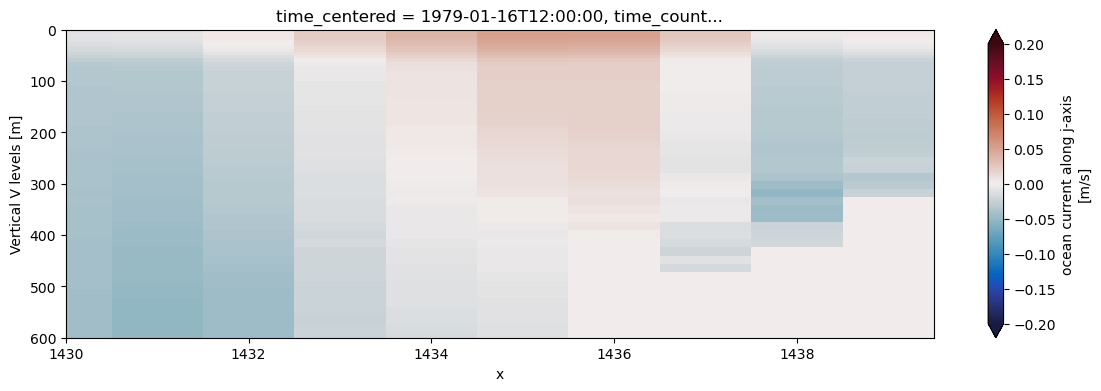

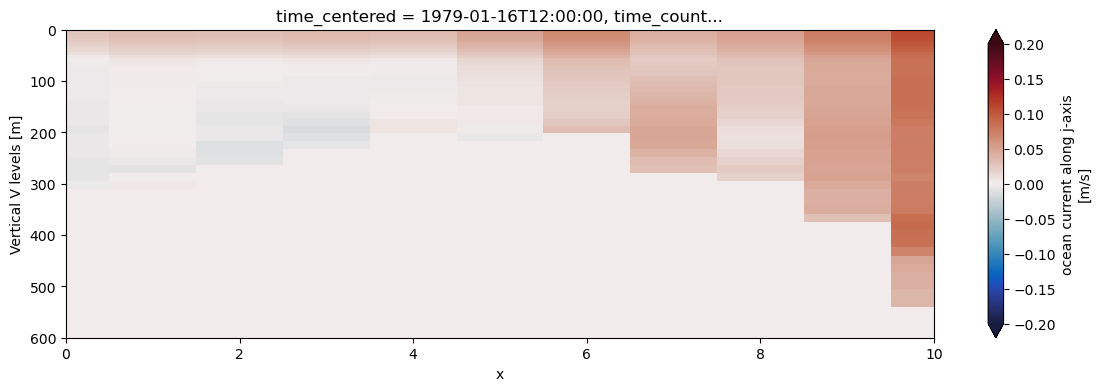

In [219]:
dsv.vo.isel(y=-3).plot(xlim=(1430,None), **kwagsV)
dsv.vo.isel(y=-3).plot(xlim=(0,10), **kwagsV)

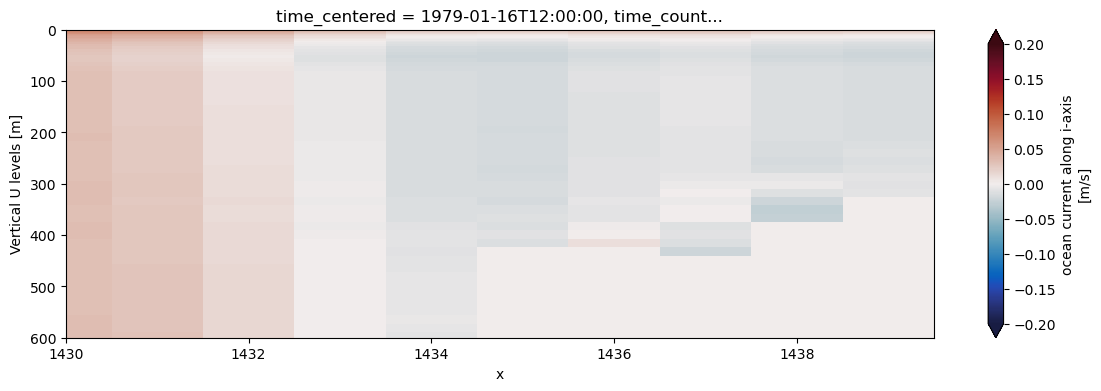

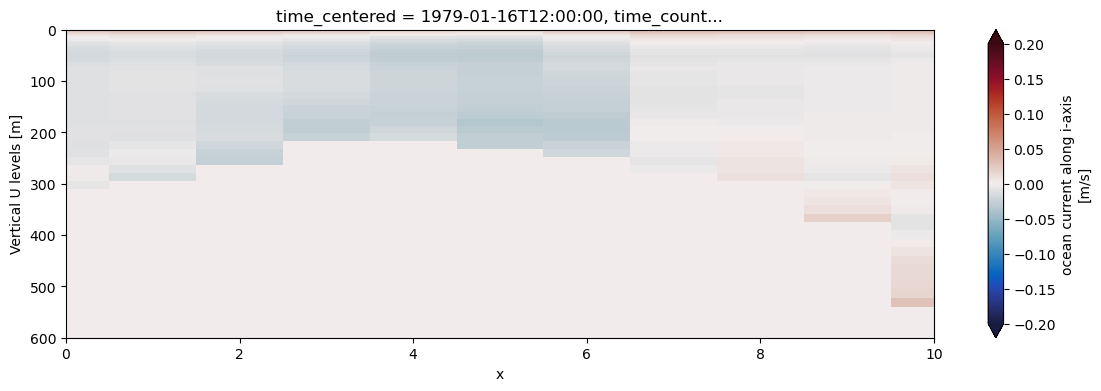

In [222]:
dsu.uo.isel(y=-2).plot(xlim=(1430,None), **kwagsU)
dsu.uo.isel(y=-2).plot(xlim=(0,10), **kwagsU)

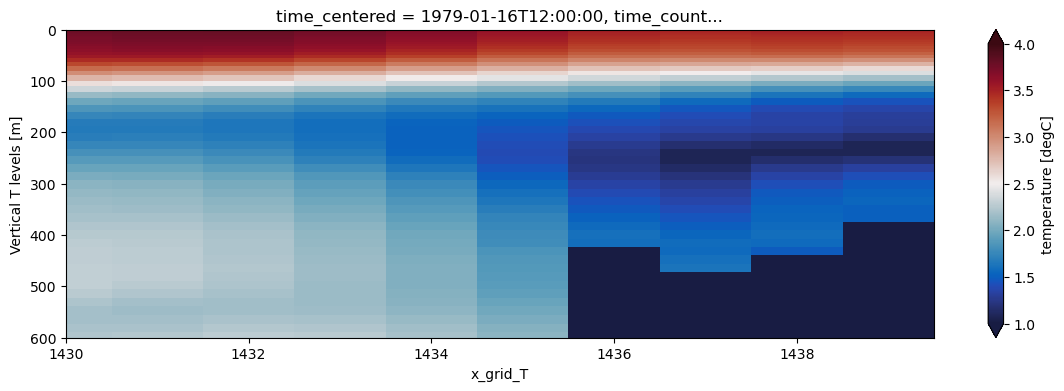

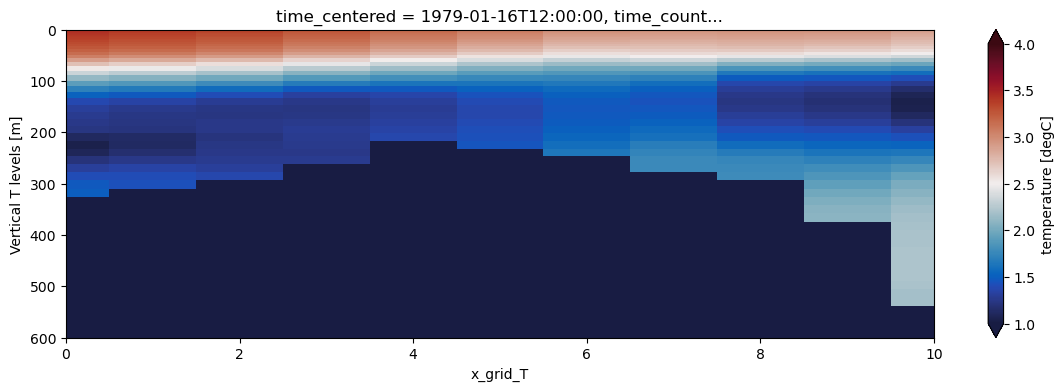

In [233]:
dst.thetao.isel(y_grid_T=-2).plot(xlim=(1430,None), **kwagsT)
dst.thetao.isel(y_grid_T=-2).plot(xlim=(0,10), **kwagsT)

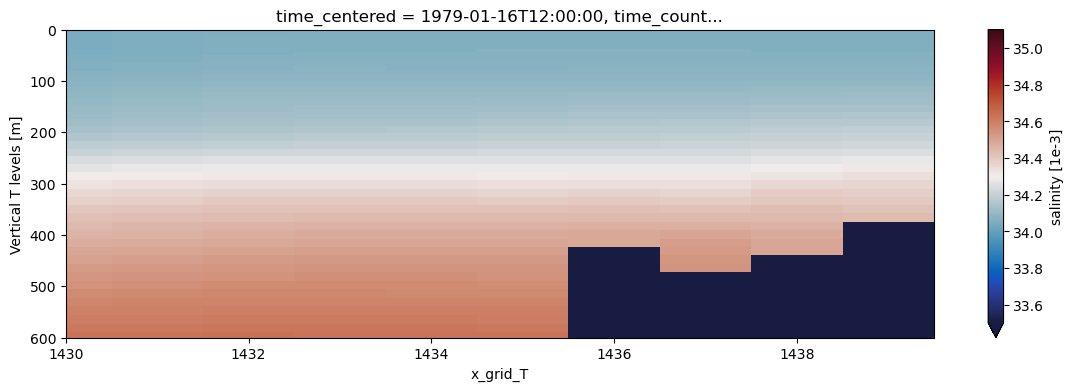

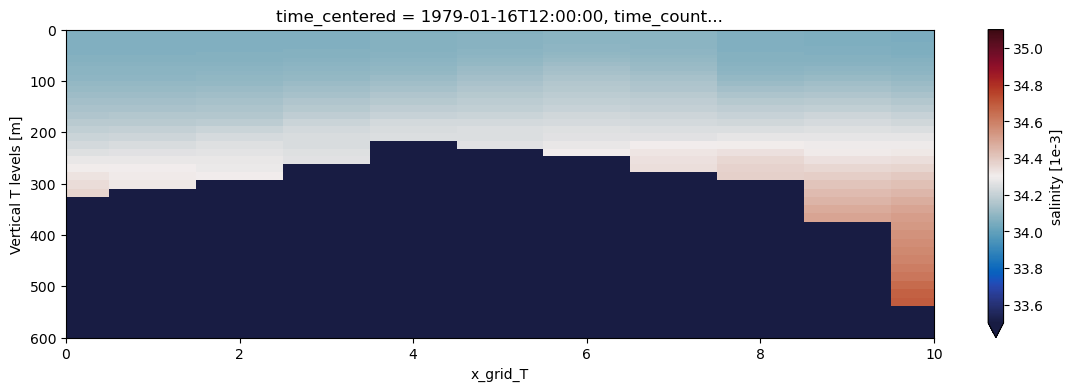

In [231]:
dst.so.isel(y_grid_T=-2).plot(xlim=(1430,None), **kwagsS)
dst.so.isel(y_grid_T=-2).plot(xlim=(0,10), **kwagsS)

## What about if I just fill everywhere near the boundaries with constant U,V,W,T values?

In [33]:
dso.x.size

1440

In [35]:
for var in ['AbsSal', 'ConsTemp', 'UVEL', 'VVEL','SSH','aice','sithick','sisnthick']:
    print(var)
    for month in range(2,13):
        dso = xr.open_dataset(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_{var}_test4_y1850m{month:02}.nc')
        dso_array  = np.copy(dso[var].values)
        slice_fill = dso[var].isel(x=451).values
        if var in ['AbsSal', 'ConsTemp', 'UVEL', 'VVEL']:
            for x in range(0,dso.x.size):
                dso_array[:,:,:,x] = slice_fill
            
            dso_array = xr.where(dso[var].values==9999, 9999, dso_array)
            dsn = dso.copy()
            dsn[var] = (('time_counter','deptht','y','x'), dso_array)
        else:
            for x in range(0,dso.x.size):
                dso_array[:,:,x] = slice_fill
            
            dso_array = xr.where(dso[var].values==9999, 9999, dso_array)
            dsn = dso.copy()
            dsn[var] = (('time_counter','y','x'), dso_array)
            
        dsn.to_netcdf(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_{var}_test8_y1850m{month:02}.nc')

AbsSal
ConsTemp
UVEL
VVEL
SSH
aice
sithick
sisnthick


In [13]:
var = 'AbsSal'
month = 2
dso = xr.open_dataset(f'{base_folder}boundary-conditions/CESM2/LE2/CESM2-LE2_ens1011.001_BCs_{var}_test4_y1850m{month:02}.nc')
dso_array  = np.copy(dso[var].values)
slice_fill = dso[var].isel(x=451).values

In [14]:
dso_array  = np.copy(dso[var].values)
slice_fill = dso[var].isel(x=451).values
for x in range(0,1440):
    dso_array[:,:,:,x] = slice_fill

dso_array = xr.where(dso[var].values==9999, 9999, dso_array)
dsn = dso.copy()
dsn[var] = (('time_counter','deptht','y','x'), dso_array)

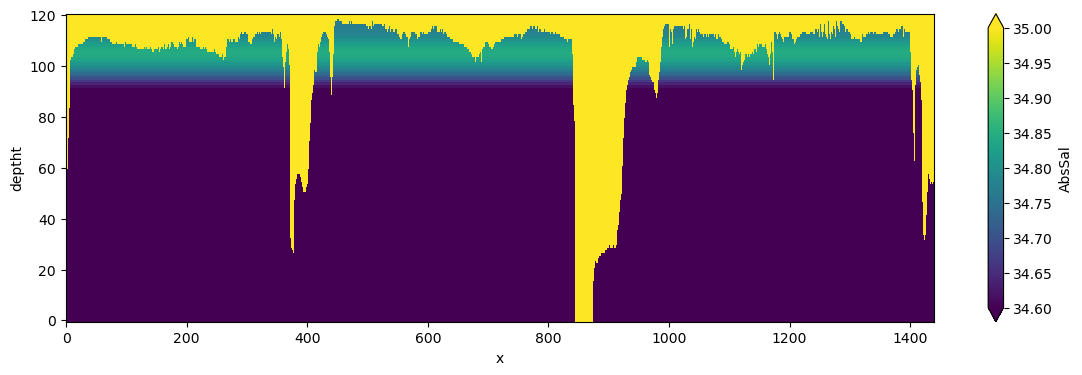

In [17]:
dsn[var].isel(time_counter=0,y=0).plot(figsize=(14,4), vmin=34.6, vmax=35)

## Organize functions for new CESM2 initial conditions creation

In [3]:
# Helper function to 
def fill_and_reshape(ds, variable, land_fill_val=9999, dim='3D'):
    # Fill nan values with an unrealistic constant value
    ds[variable] = xr.where(np.isnan(ds[variable]), land_fill_val, ds[variable])

    # Reshape array
    if dim=='3D':
        ds[variable] = xr.where(ds.z == ds.z[-1], ds[variable].isel(z=-2), ds[variable]) # fill bottom grid cell with value from above it
        ds[variable] = ('time_counter','deptht','y','x'), ds[variable].values[np.newaxis, ...] # add a time axis
    elif dim=='2D':
        ds[variable] = ('time_counter','y','x'), ds[variable].values[np.newaxis, ...] # add a time axis           
    return ds

In [4]:
def regrid_cesm2_nemo_cf(cesm2_source, variable, dim='3D'):

    if dim=='3D':
        with open('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/cf-regridding/linear-regrid-CESM2-eANT025-z0-z70.pickle','rb') as file:
            rgo1 = pickle.load(file)
            ds1  = regrid_array_cf(cesm2_source, rgo1, key_3d=True, method='linear', src_cyclic=True, dst_cyclic=True)
        with open('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/cf-regridding/linear-regrid-CESM2-eANT025-z70-z121.pickle','rb') as file:
            rgo2 = pickle.load(file)
            ds2  = regrid_array_cf(cesm2_source, rgo2, key_3d=True, method='linear', src_cyclic=True, dst_cyclic=True)
        # combine pickles from both interpolations
        ds_array = np.vstack((ds1.array, ds2.array))
    elif dim=='2D':
        with open('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/cf-regridding/linear-regrid-CESM2-eANT025-z0.pickle','rb') as file:
            rgo1 = pickle.load(file)
            ds1  = regrid_array_cf(cesm2_source, rgo1, key_3d=False, method='linear', src_cyclic=True, dst_cyclic=True)
            ds_array = ds1.array

    # Replace zeros with NaN
    ds_array_masked = xr.where(ds_array==0, np.nan, ds_array)
    if dim=='3D':
        ds = xr.Dataset({variable:(('z','y','x'), ds_array_masked)})
    elif dim=='2D':
        ds = xr.Dataset({variable:(('y','x'), ds_array_masked)})

    return ds

In [5]:
def cesm2_bcs(variable, exp='LE2', ens='1011.001', dim='3D', year=1850, land_fill_val=9999, gtype='T',
              cesm2_folder='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/',
              out_folder='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/boundary-conditions/CESM2/LE2/',
              nemo_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):
    if dim=='3D':
        name_remapping = {variable:'data', 'TLONG':'lon', 'TLAT':'lat', 'nlat':'y', 'nlon':'x', 'z_t':'z'}
    elif dim=='2D':
        if variable in ['aice','sisnthick','sithick']:
            name_remapping = {variable:'data', 'TLON':'lon', 'TLAT':'lat', 'nj':'y', 'ni':'x'}
        else:
            name_remapping = {variable:'data', 'TLONG':'lon', 'TLAT':'lat', 'nlat':'y', 'nlon':'x'}

    # load NEMO grid:
    nemo_mask_ds = xr.open_dataset(nemo_mask)
    # load CESM2 file and specified month, rename variables:
    cesm2_ds     = xr.open_dataset(f'{cesm2_folder}CESM2-LE2_ens{ens}_{variable}_y{year}.nc')

    if year==1850:
        month_range = range(2,12+1)
    else:
        month_range = range(1,12+1)
    
    for month in month_range:
        cesm2_ds_month = cesm2_ds.isel(time=(cesm2_ds.time.dt.month==month)).isel(time=0)
        if dim=='3D':
            cesm2_ds_month = cesm2_ds_month.assign({'depth':cesm2_ds.z_t})
        cesm2_source = cesm2_ds_month.rename(name_remapping)
    
        # interpolate CESM2 grid to NEMO grid and fill empty values with connected nearest neighbour
        cesm2_interp   = regrid_cesm2_nemo_cf(cesm2_source, variable, dim=dim)
        # extract the boundary layer:
        if gtype=='V':
            slice1 = slice(-2,-1); slice2 = slice(-3,-2);
        else:
            slice1 = slice(-1,None); slice2 = slice(-2,-1);
        slice1=slice2;
        cesm2_interp   = cesm2_interp.isel(y=slice1)
        cesm2_extended = fill_ocean(cesm2_interp, variable, nemo_mask_ds.isel(y=slice2), dim=dim, niter=400, fill_val=np.nan, grid=gtype)
        cesm2_extended[variable] = cesm2_extended[variable].roll(x=-1) # because of Fortran based indexing
    
        # Fill land values with an unrealistic constant value and add a time dimension to the shape
        CESM2_bcs = fill_and_reshape(cesm2_extended, variable, land_fill_val=land_fill_val, dim=dim)
    
        # Write output to file:
        CESM2_bcs.to_netcdf(f'{out_folder}CESM2-{exp}_ens{ens}_BCs_{variable}_test4_y{year}m{month:02}.nc', unlimited_dims='time_counter')

    return

In [40]:
# ConsTemp, AbsSal
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('ConsTemp', year=year, exp='LE2', ens='1011.001', dim='3D', gtype='T')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 77.25it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:03, 98.97it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:05, 70.45it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 80.96it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:05, 71.05it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 92.17it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:05, 74.31it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:03, 98.62it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 95.75it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:03, 100.59it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:05, 71.88it/s]


Completed filling missing values


In [41]:
# ConsTemp, AbsSal
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('AbsSal', year=year, exp='LE2', ens='1011.001', dim='3D', gtype='T')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 95.63it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 92.85it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 95.81it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:03, 99.77it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 94.06it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 94.02it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:04, 84.61it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:05, 71.31it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:03, 97.12it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:05, 74.39it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  4%|▍         | 15/400 [00:00<00:03, 97.05it/s]

Completed filling missing values


In [42]:
# aice, sithick, sisnthick, SSH
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('aice', year=year, exp='LE2', ens='1011.001', dim='2D', land_fill_val=0, gtype='T')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1643.97it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1475.31it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2002.05it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1903.91it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1605.99it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1622.35it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1533.38it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1258.29it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1562.90it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2180.75it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1554.60it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


In [43]:
# aice, sithick, sisnthick, SSH
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('sithick', year=year, exp='LE2', ens='1011.001', dim='2D', land_fill_val=0, gtype='T')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 778.74it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1426.31it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1898.73it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1458.55it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1854.79it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1270.87it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1522.07it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2012.30it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 848.65it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2274.57it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 982.73it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


In [44]:
# aice, sithick, sisnthick, SSH
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('sisnthick', year=year, exp='LE2', ens='1011.001', dim='2D', land_fill_val=0, gtype='T')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1611.13it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1472.37it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 917.59it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2038.05it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1430.20it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2056.03it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2384.93it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 978.23it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2475.98it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1033.59it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1841.49it/s]

Previous loop was unable to fill more missing values, so filled with constant nan
location of missing vals: [[   0    0]
 [   0    1]
 [   0    2]
 ...
 [   0 1437]
 [   0 1438]
 [   0 1439]]
Completed filling missing values


In [45]:
# aice, sithick, sisnthick, SSH
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('SSH', year=year, exp='LE2', ens='1011.001', dim='2D', land_fill_val=0, gtype='T')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2981.03it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2604.08it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 3273.39it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2755.18it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1278.88it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1455.51it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1292.41it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2082.23it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2086.37it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 2851.97it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  1%|          | 3/400 [00:00<00:00, 1652.60it/s]

Completed filling missing values


In [46]:
# UVEL
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('UVEL', year=year, exp='LE2', ens='1011.001', dim='3D', land_fill_val=0, gtype='U')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:05, 77.53it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:04, 94.35it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:04, 94.85it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:05, 69.00it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:03, 105.13it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:04, 82.30it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:03, 102.61it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:05, 73.02it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:04, 86.93it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:04, 89.43it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  3%|▎         | 12/400 [00:00<00:05, 68.46it/s]

Completed filling missing values


In [47]:
# VVEL
for year in range(1850, 1851):
    print('------ year:', year, '------')
    cesm2_bcs('VVEL', year=year, exp='LE2', ens='1011.001', dim='3D', land_fill_val=0, gtype='V')

------ year: 1850 ------
Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:04, 90.54it/s]


Completed filling missing values
Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:05, 72.27it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:04, 88.69it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:04, 98.36it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:04, 90.20it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:05, 66.77it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:03, 107.13it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:04, 90.86it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:03, 99.18it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:04, 96.51it/s]

Completed filling missing values


Filling gaps with connected nearest neighbours


  2%|▏         | 6/400 [00:00<00:06, 61.12it/s]

Completed filling missing values
